In [1]:
import dadrah.analysis.root_plotting_util as rpu
import dadrah.util.run_paths as runpa
import dadrah.util.string_constants as stco
import dadrah.selection.selection_util as seut
import pofah.jet_sample as js
import pofah.phase_space.cut_constants as cuts
import dadrah.kfold_pipeline.kfold_string_constants as kstco
import dadrah.kfold_pipeline.kfold_util as kutil

import pathlib
import argparse
import scipy
from scipy.stats import kstwo
from scipy.stats import chi2

import numpy as np
import ROOT as rt
import root_numpy as rtnp
import uuid
import os
from recordtype import recordtype
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm
import root_numpy as rtnp
import mplhep as hep
plt.style.use(hep.style.ROOT)
import cmsstyle #mplhep for Python2 cheatsheet

Welcome to JupyROOT 6.22/00


In [2]:
scipy.__version__

'1.5.1'

## runtime params

### change:

In [3]:
Parameters = recordtype('Parameters','qr_run_n, quantiles, qcd_sample_id, sig_sample_id, sig_xsec, score_strategy_id, read_n, env_run_n, poly_run_n')
params = Parameters(qr_run_n=416,
                    quantiles=[0.3, 0.5, 0.7, 0.9],
                    qcd_sample_id='qcdSigAll', 
                    sig_sample_id='GtoWW15brReco',
                    sig_xsec=0,
                    score_strategy_id='rk5_05',
                    read_n=None,
                    env_run_n=0,
                    poly_run_n=0,
                    )

qr_model_str = '_'.join(['kfold',str(params.qr_run_n),str(params.env_run_n),str(params.poly_run_n)])
train_share = 0

mX = 1.5
sample_id_qcd = 'qcdSigAllTest'+str(int((1-train_share)*100))+'pct' if train_share else 'qcdSigAll'
sample_id_sig = 'GtoWW35naReco'
sample_ids = [sample_id_qcd, sample_id_sig]

# choose which template quantile to use (0 = 0.9-1.0, 1 = 0.7-0.9)
template_q_idx = 0

# paths
input_path = kstco.get_polynomials_out_data_dir(params)
fig_dir = 'fig/qr_run_'+str(int(params.qr_run_n))+'/env_run_'+str(int(params.env_run_n))+'/poly_run_'+str(int(params.poly_run_n))
pathlib.Path(fig_dir).mkdir(parents=True, exist_ok=True)

xsecs_sig   = [0,20,40,60,80,100] # signal cross sections

file_name_root_hist = 'histograms_injSig_PDinj_NA3p5_r'+str(params.qr_run_n)+'.root'
#quants = [0.0, 0.3, 0.5, 0.7, 0.9, 0.99]
quants = [0.0, 0.3, 0.5, 0.7, 0.9]
#quants = [0.0, 0.7]

In [4]:
xsec_train = 0 # signal cross section used when training the QR
mX = 3.5
sample_id_qcd = 'qcdSigAllTest'+str(int((1-train_share)*100))+'pct' if train_share else 'qcdSigAll'
sample_id_sig = 'GtoWW35naReco'
sample_ids = [sample_id_qcd, sample_id_sig]
template_q_idx = 0
quant_tmplt = quants[template_q_idx]

In [5]:
# if poly_cut:
#     paths = runpa.RunPaths(in_data_dir=stco.dir_path_dict['base_dir_qr_selections_poly_cut'], in_data_names=stco.file_name_path_dict, out_data_dir=stco.dir_path_dict['base_dir_qr_analysis'])
#     path_ext_dict = {'vae_run': str(ae_run_n), 'qr_run': str(qr_run_n), 'sig': sample_id_sig[:-4], 'xsec': str(int(xsec_train)), 'loss': 'rk5_05', 'order':'5'}
# else:
#     paths = runpa.RunPaths(in_data_dir=stco.dir_path_dict['base_dir_qr_selections'], in_data_names=stco.file_name_path_dict, out_data_dir=stco.dir_path_dict['base_dir_qr_analysis'])
#     path_ext_dict = {'vae_run': str(ae_run_n), 'qr_run': str(qr_run_n), 'sig': sample_id_sig, 'xsec': str(int(xsec_train)), 'loss': 'rk5_05'}
# paths.extend_in_path_data(path_ext_dict)
# paths.extend_out_path_data({**path_ext_dict, 'hypothesis_testing': None})

### fixed

In [6]:
# Rescaling the inputs to lumi
qcd_xsec         = 8730000.0 # Crossection in fb             
qcd_gen_events   = 134366091.0+199435365.0+90490645.0+134264102.0 #(all generated QCD)
sig_xsec_default = 10. #In units of fb (10 fb == 0.01 pb) 
sig_gen_events   = 972050.0 #(all generated signal)
lumi             = qcd_gen_events/qcd_xsec # assuming 64/fb since qcd_gen_events/8730000 ~ 64

scale_qcd = qcd_xsec*lumi/qcd_gen_events
scale_sig = (1-train_share)*sig_xsec_default*lumi/sig_gen_events #X% already used for quantile regression, must be removed
print('Usign luminosity {}'.format(lumi))
print('Scale QCD with {}'.format(scale_qcd))
print('Scale signal with {}'.format(scale_sig))

Usign luminosity 63.98123745704467
Scale QCD with 1.0
Scale signal with 0.0006582093252100682


In [7]:
# efficiencies
quants_tmp = np.asarray(quants+[1.])
effs = (quants_tmp)[template_q_idx+1:] - (quants_tmp)[template_q_idx:-1]
effs = effs[1:]/effs[0] # scale down instead of up (apply to template quantile)

In [8]:
effs

array([0.66666667, 0.66666667, 0.66666667, 0.33333333])

In [9]:
min_mjj = 1200.
max_mjj = 5400.

bin_edges = kutil.get_bins_from_envelope(params)
bin_edges = bin_edges[(bin_edges>=min_mjj) & (bin_edges<=max_mjj)]
n_bins = len(bin_edges)-1
max_bin = bin_edges[-1]
min_bin = bin_edges[0]

In [10]:
bin_edges

array([1227.5, 1287.5, 1353.5, 1422. , 1493. , 1566.5, 1642.5, 1721. ,
       1802.5, 1887. , 1974.5, 2065. , 2158.5, 2255.5, 2355.5, 2459. ,
       2566. , 2676.5, 2791. , 2909. , 3031. , 3157. , 3287. , 3421.5,
       3561. , 3705. , 3853. , 4006. , 4164.5, 4328. , 4497. , 4671.5,
       4851.5, 5037.5, 5229.5])

In [11]:
min_mjj = bin_edges[0]

## read histogram data

In [12]:
def read_root_hist_data(file_name):
    
    hist_data = {}
    ff = rt.TFile.Open(file_name,'r')

    # read bins from template quantile
    dat = ff.Get('data_acc_{}fb_q{}p'.format(0,int(100))); dat.SetDirectory(0);
    bin_centers = np.asarray([dat.GetXaxis().GetBinCenter(j) for j in range(1,dat.GetNbinsX()+1)])

    # for each quantile
    for i, quant in enumerate(quants):

        hist_data_quant = {}
        q_key = quants[i]*100

        # for each signal injection
        for xsec in xsecs_sig:

            dat = ff.Get('data_acc_{}fb_q{}p'.format(xsec,int(q_key))); dat.SetDirectory(0);
            yy = np.asarray([dat.GetBinContent(j) for j in range(1,dat.GetNbinsX()+1)])

            hist_data_quant[xsec] = yy

        hist_data[quant] = hist_data_quant
        
    return bin_centers, hist_data

In [13]:
def read_raw_selection_data(quantiles, ae_run_n, qr_run_n, sample_id_sig, xsec_train, paths):
    samples = {}

#     for sample_id in sample_ids:
#         samples[sample_id] = js.JetSample.from_input_file(sample_id, paths.in_file_path(sample_id), **cuts.signalregion_cuts)
        
    for sample_id in sample_ids:
        in_path = os.path.join(paths,sample_id+'.h5') #paths.in_file_path(sample_id)
        samples[sample_id] = js.JetSample.from_input_file(sample_id, in_path)
        print('read ' + str(len(samples[sample_id])) + ' ' + sample_id + ' samples from ' + in_path)
    
    # qcd raw data
    samples_ortho_quantiles_qcd = seut.divide_sample_into_orthogonal_quantiles(samples[sample_id_qcd], quantiles[1:])
    mjj_vals_qcd = [sample_ortho['mJJ'] for sample_ortho in samples_ortho_quantiles_qcd]
    # signal raw data
    samples_ortho_quantiles_sig = seut.divide_sample_into_orthogonal_quantiles(samples[sample_id_sig], quantiles[1:])
    mjj_vals_sig = [sample_ortho['mJJ'] for sample_ortho in samples_ortho_quantiles_sig]
    
    return mjj_vals_qcd, mjj_vals_sig

In [14]:
def read_raw_selection_data_to_numpy_hist(quantiles, ae_run_n, qr_run_n, sample_id_sig, xsec_train, bin_edges, paths):
    
    mjj_vals_qcd, mjj_vals_sig = read_raw_selection_data(quantiles, ae_run_n, qr_run_n, sample_id_sig, xsec_train, paths)
    
    datas_qcd = {}
    datas_sig = {}
    
    # qcd histogram data
    for mjj, q in zip(mjj_vals_qcd[template_q_idx:], quantiles[template_q_idx:]):
        counts, _, _ = plt.hist(mjj, bins=bin_edges)
        datas_qcd[q] = counts
        
    # sig histogram data
    for mjj, q in zip(mjj_vals_sig[template_q_idx:], quantiles[template_q_idx:]):
        counts, _, _ = plt.hist(mjj, bins=bin_edges)
        datas_sig[q] = counts
    
    # make signal injection dataset for all signal xsecs
    histos_data_inj = {}
    
     # for each quantile
    for quant in quantiles[template_q_idx:]:
        
        histos_data_inj_quant = {}
        
        # for each signal cross section (each signal injection value)
        for xsec in xsecs_sig:
        
            # get qcd data
            dat = datas_qcd[quant]
            # add signal data according to cross section
            scale_xsec_sig = xsec/sig_xsec_default
            sig_inj = datas_sig[quant]*scale_sig*scale_xsec_sig
            # TODO: sample sig bin height from poisson?
            
            histos_data_inj_quant[xsec] = dat + sig_inj
            
        histos_data_inj[quant] = histos_data_inj_quant
            
    return bin_edges[:-1], histos_data_inj     
    

read 11985958 qcdSigAll samples from /eos/user/k/kiwoznia/data/QR_results/events/qr_run_416/env_run_0/poly_run_0/qcdSigAll.h5
read 531825 GtoWW35naReco samples from /eos/user/k/kiwoznia/data/QR_results/events/qr_run_416/env_run_0/poly_run_0/GtoWW35naReco.h5


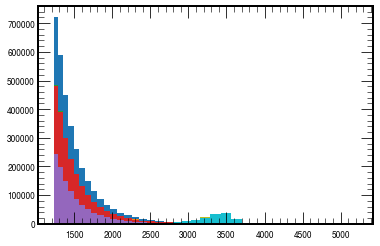

In [15]:
#bin_centers, hist_data = read_root_hist_data(file_name_root_hist)
bin_centers, hist_data = read_raw_selection_data_to_numpy_hist(quants, 113, params.qr_run_n, sample_id_sig, xsec_train, bin_edges, input_path)

In [16]:
quants

[0.0, 0.3, 0.5, 0.7, 0.9]

## plot histograms

/cvmfs/sft.cern.ch/lcg/views/LCG_98python3/x86_64-centos7-gcc10-opt/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  after removing the cwd from sys.path.


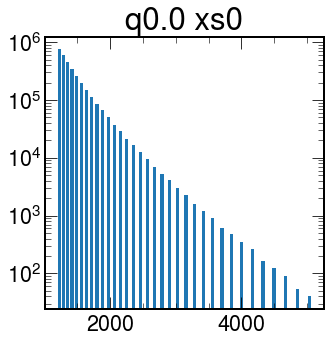

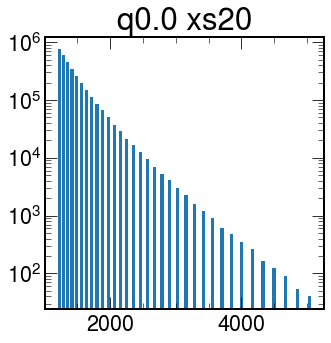

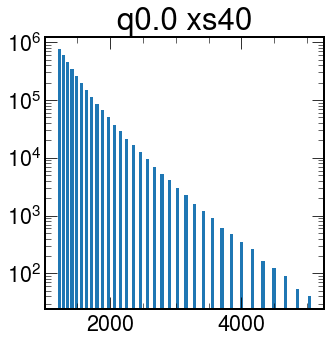

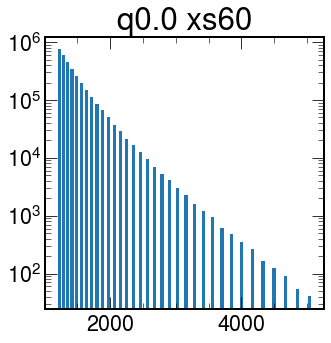

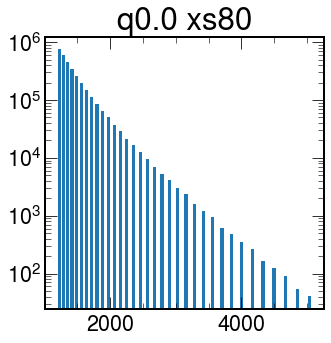

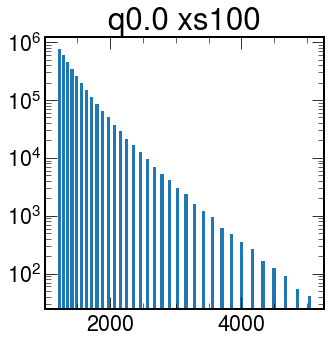

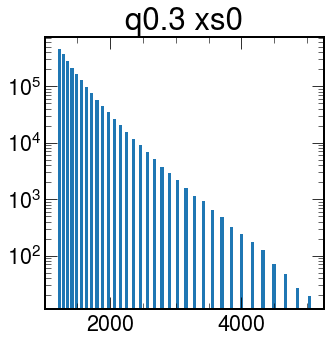

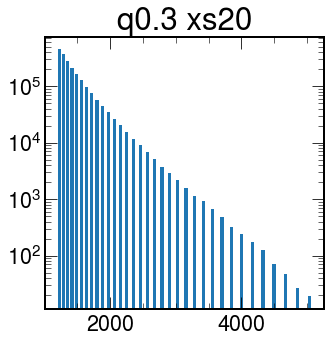

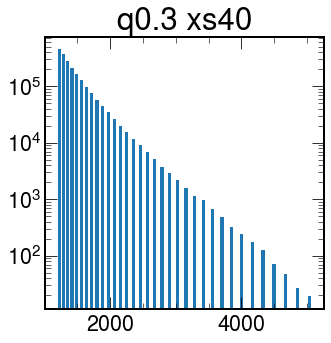

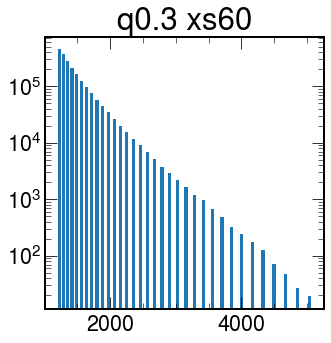

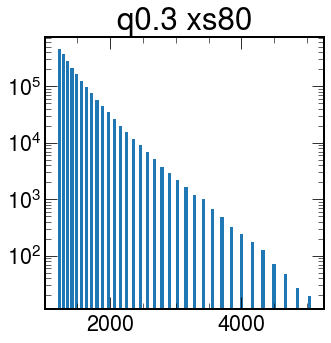

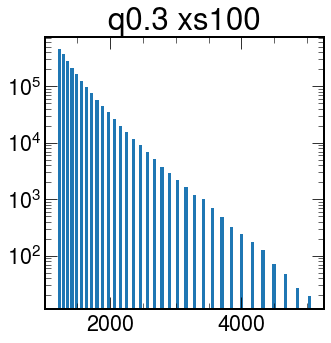

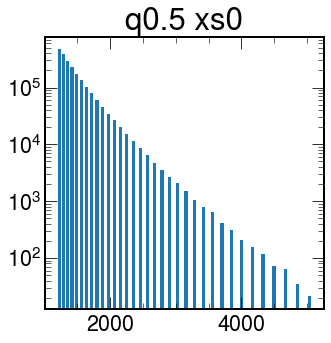

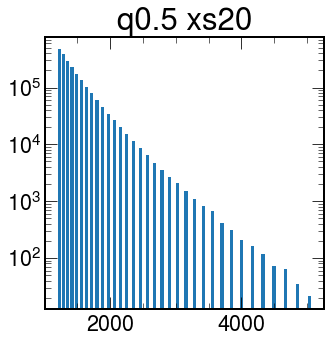

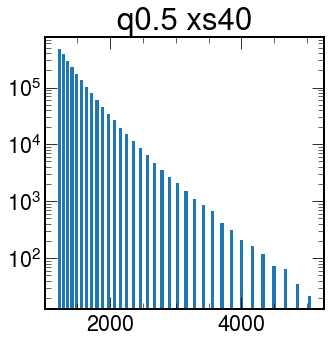

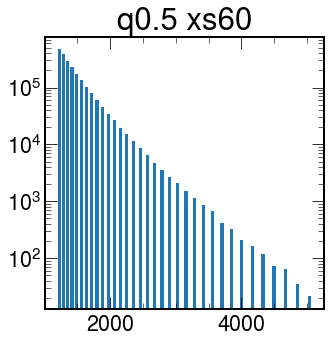

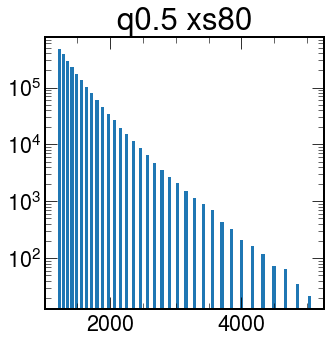

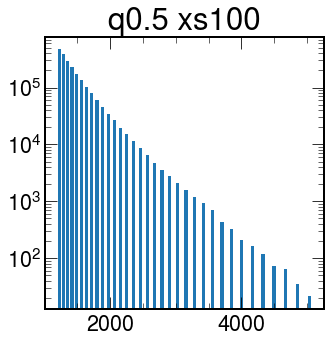

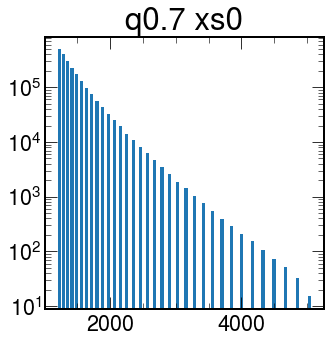

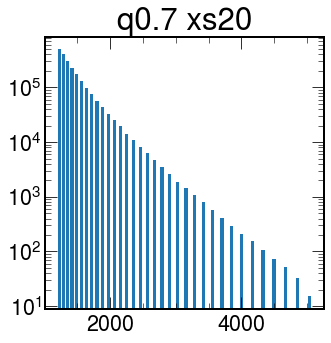

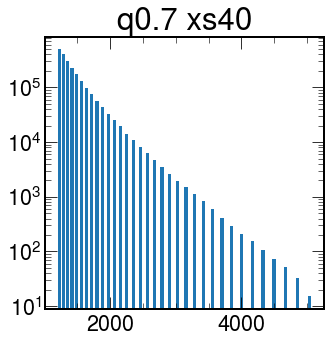

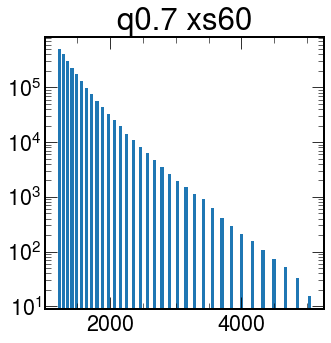

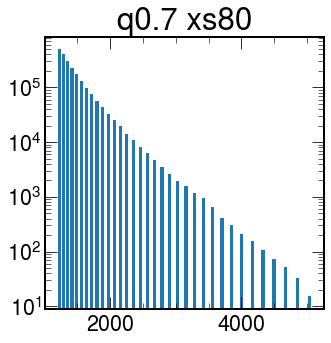

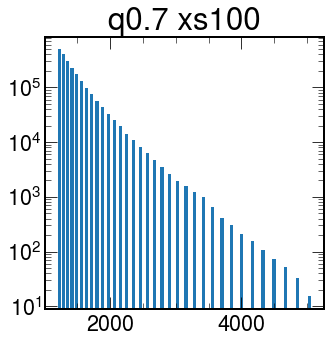

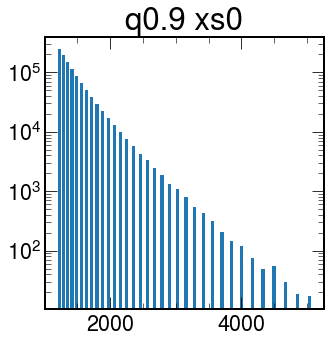

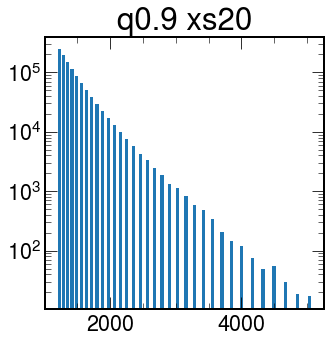

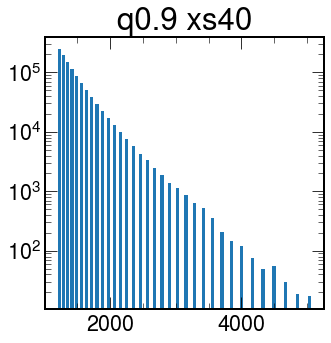

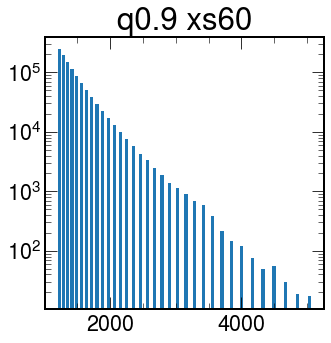

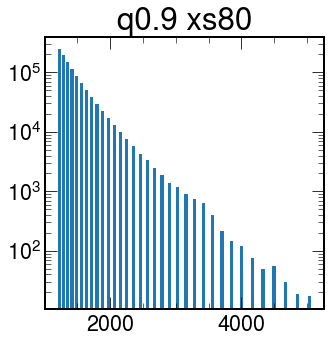

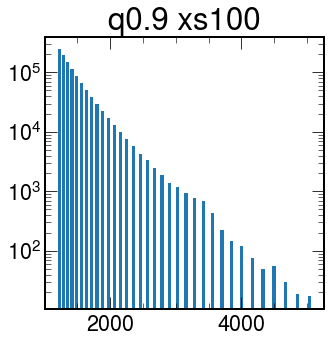

In [52]:
for quant in quants[template_q_idx:]:
    for xsec in xsecs_sig:
        yy = hist_data[quant][xsec]
        plt.figure(figsize=(5, 5))
        plt.bar(bin_centers, yy, width=50, log=True)
        plt.title('q{} xs{}'.format(quant, xsec))

In [17]:
# print N samples
for quant in quants[template_q_idx:]:
    for xsec in xsecs_sig:
        yy = hist_data[quant][xsec]
        print('quant {:>4}, xsec {:>3}: {:>8} events'.format(quant, xsec, int(sum(yy))))

quant  0.0, xsec   0:  3183809 events
quant  0.0, xsec  20:  3183899 events
quant  0.0, xsec  40:  3183990 events
quant  0.0, xsec  60:  3184081 events
quant  0.0, xsec  80:  3184172 events
quant  0.0, xsec 100:  3184263 events
quant  0.3, xsec   0:  2123132 events
quant  0.3, xsec  20:  2123215 events
quant  0.3, xsec  40:  2123298 events
quant  0.3, xsec  60:  2123381 events
quant  0.3, xsec  80:  2123464 events
quant  0.3, xsec 100:  2123547 events
quant  0.5, xsec   0:  2126671 events
quant  0.5, xsec  20:  2126789 events
quant  0.5, xsec  40:  2126908 events
quant  0.5, xsec  60:  2127027 events
quant  0.5, xsec  80:  2127145 events
quant  0.5, xsec 100:  2127264 events
quant  0.7, xsec   0:  2116132 events
quant  0.7, xsec  20:  2116341 events
quant  0.7, xsec  40:  2116550 events
quant  0.7, xsec  60:  2116760 events
quant  0.7, xsec  80:  2116969 events
quant  0.7, xsec 100:  2117179 events
quant  0.9, xsec   0:  1065745 events
quant  0.9, xsec  20:  1065942 events
quant  0.9, 

# Chi Square tests

In [18]:
def chi_square_pearson(observed, expected):
    statistics_per_bin = [(o-e)**2/e for o, e in zip(observed, expected)]
    return sum(statistics_per_bin), statistics_per_bin

In [19]:
def chi_square_neyman(observed, expected):
    statistics_per_bin = [(o-e)**2/max(o,1) for o, e in zip(observed, expected)] # adapted to zero bin counts
    return sum(statistics_per_bin), statistics_per_bin

In [20]:
def chi_square_poisson_likeli(observed, expected):
    statistics_per_bin = [2*(e - o + (o * np.log(o/e) if o else 0)) for o, e in zip(observed, expected)]
    return sum(statistics_per_bin), statistics_per_bin

In [21]:
np.set_printoptions(precision=4, suppress=False)

In [22]:
df = n_bins - 1 # degrees of freedom = number of measurements (=bins) - 1

chi_sq_pearson_stats = {}
chi_sq_neyman_stats = {}
chi_sq_poisson_like = {}

for quant_test, eff in zip(quants[template_q_idx+1:], effs):
    
    test_stat_xsecs_p = []
    pvals_p = []
    test_stat_xsecs_n = []
    pvals_n = []
    test_stat_xsecs_l = []
    pvals_l = []
    
    for xsec in xsecs_sig:
        observed = hist_data[quant_test][xsec]
        expected = hist_data[quant_tmplt][xsec]*eff
        t_p, _ = chi_square_pearson(observed, expected)
        pval_p = 1 - chi2.cdf(t_p, df=df)
        t_n, _ = chi_square_neyman(observed, expected)
        pval_n = 1 - chi2.cdf(t_n, df=df)
        t_l, _ = chi_square_poisson_likeli(observed, expected)
        pval_l = 1 - chi2.cdf(t_l, df=df)
        test_stat_xsecs_p.append(t_p)
        test_stat_xsecs_n.append(t_n)
        test_stat_xsecs_l.append(t_l)
        pvals_p.append(pval_p)
        pvals_n.append(pval_n)
        pvals_l.append(pval_l)
    
    print('pearson for quantile', quant_test)
    print('ch2:' , np.array(test_stat_xsecs_p))
    print('p-val: ', np.array(pvals_p))
    print('neyman for quantile', quant_test)
    print(np.array(test_stat_xsecs_n))
    print('p-val: ', np.array(pvals_n))
    print('likelihood for quantile', quant_test)
    print(np.array(test_stat_xsecs_l))
    print('p-val: ', np.array(pvals_l))
    print('\n')
    
    chi_sq_pearson_stats[quant_test] = test_stat_xsecs_p
    chi_sq_neyman_stats[quant_test] = test_stat_xsecs_n
    chi_sq_poisson_like[quant_test] = test_stat_xsecs_l

pearson for quantile 0.3
ch2: [62.1867 63.4556 65.0916 67.0881 69.4387 72.1371]
p-val:  [1.5669e-03 1.1179e-03 7.1765e-04 4.1301e-04 2.1220e-04 9.6889e-05]
neyman for quantile 0.3
[66.1362 67.0673 68.3243 69.895  71.7679 73.9322]
p-val:  [5.3832e-04 4.1542e-04 2.9157e-04 1.8612e-04 1.0799e-04 5.6894e-05]
likelihood for quantile 0.3
[63.1363 64.289  65.7933 67.6406 69.8224 72.3307]
p-val:  [1.2177e-03 8.9294e-04 5.9183e-04 3.5369e-04 1.9005e-04 9.1520e-05]


pearson for quantile 0.5
ch2: [ 75.999   78.598   82.9505  89.0243  96.7882 106.2116]
p-val:  [3.0511e-05 1.3734e-05 3.4869e-06 4.8255e-07 3.4978e-08 1.2778e-09]
neyman for quantile 0.5
[ 81.8167  84.1737  88.1298  93.58   100.429  108.5903]
p-val:  [5.0032e-06 2.3550e-06 6.4856e-07 1.0472e-07 9.8850e-09 5.4371e-10]
likelihood for quantile 0.5
[ 77.4765  79.9952  84.2135  90.0729  97.5178 106.4958]
p-val:  [1.9419e-05 8.8846e-06 2.3250e-06 3.4058e-07 2.7197e-08 1.1542e-09]


pearson for quantile 0.7
ch2: [ 54.8074  62.3785  79.8679 

### draw test statistics on chi-square distribution graph

saving fig to  fig/qr_run_416/env_run_0/poly_run_0/chi_square_Pearson.png
saving fig to  fig/qr_run_416/env_run_0/poly_run_0/chi_square_Neyman.png
saving fig to  fig/qr_run_416/env_run_0/poly_run_0/chi_square_PoissonLike.png


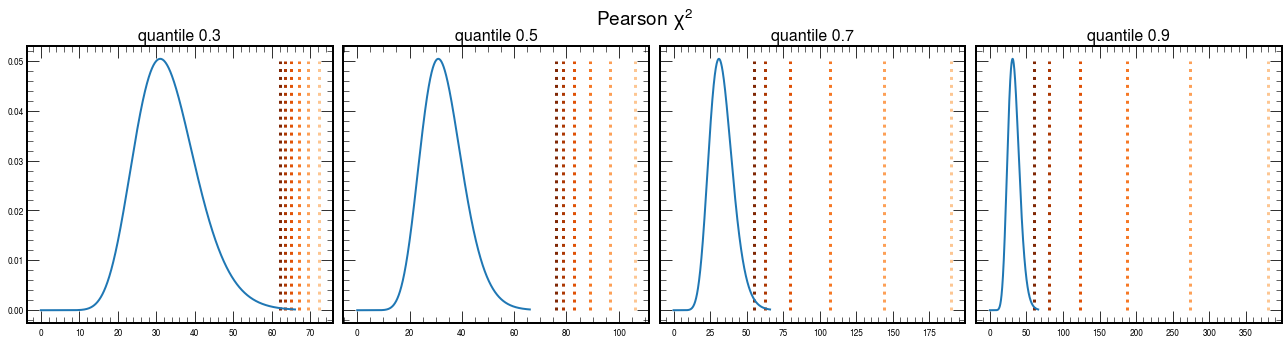

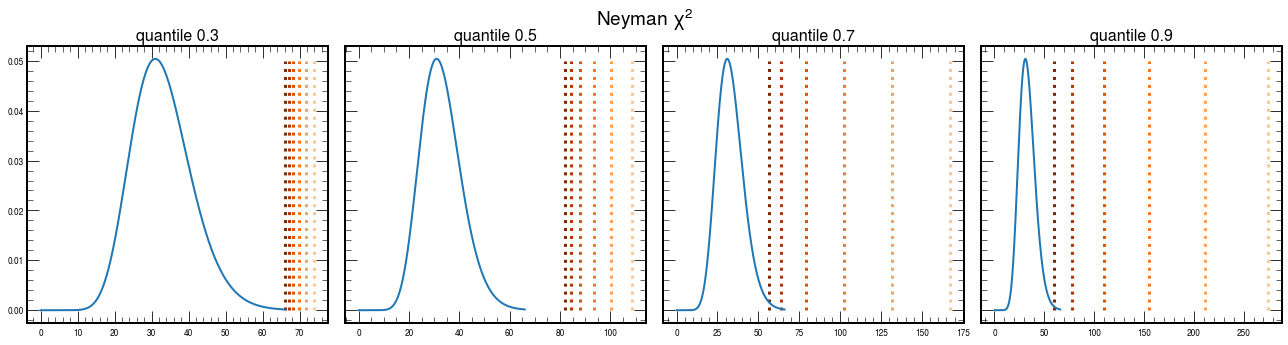

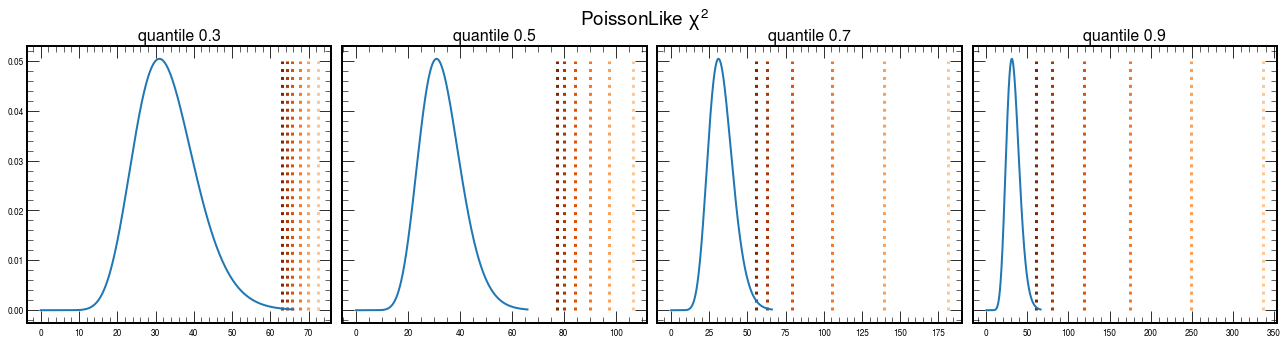

In [23]:
chi_sq_results = {
    'Pearson': chi_sq_pearson_stats,
    'Neyman' : chi_sq_neyman_stats,
    'PoissonLike': chi_sq_poisson_like
}

x = np.arange(0, df*2, 0.001)
cmap = cm.get_cmap('Oranges')
cmap = cmap(np.linspace(0.0, 1.0, len(xsecs_sig)+2))[::-1]

for method, val_dict in chi_sq_results.items():
    fig, axs = plt.subplots(1,len(quants)-1,sharey=True,figsize=(18,5))
    for quant, ax in zip(quants[template_q_idx+1:],axs.flat):
        chi_sq_vals = val_dict[quant]
        ax.plot(x, chi2.pdf(x, df=df), lw=2) # df = num-observed - 1
        ax.vlines(chi_sq_vals,colors=cmap,ymin=0,ymax=0.05, ls=':',lw=3)
        ax.set_title('quantile {}'.format(quant), fontsize=16)
    fig.suptitle(r'{} $\chi^2$'.format(method), fontsize=19)
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    fig_path = os.path.join(fig_dir,'chi_square_{}.png'.format(method))
    print('saving fig to ', fig_path)
    plt.savefig(fig_path)

In [24]:
for quant_test, eff in zip(quants[template_q_idx+1:], effs):
    test_stat_xsecs_p = []
    test_stat_xsecs_n = []
    for xsec in [xsecs_sig[0]]:
        observed = hist_data[quant_test][xsec]
        expected = hist_data[quant_tmplt][xsec]*eff
        print('\nquant ' +str(quant_test)+', xsec '+ str(xsec))
        print('obs')
        print(np.array(observed))
        print('total events ' + str(sum(observed)))
        print('exp')
        print(np.array(expected))


quant 0.3, xsec 0
obs
[4.8267e+05 3.9273e+05 2.9868e+05 2.2678e+05 1.7317e+05 1.3171e+05
 1.0007e+05 7.6214e+04 5.7781e+04 4.4301e+04 3.3845e+04 2.5665e+04
 1.9628e+04 1.5008e+04 1.1318e+04 8.6520e+03 6.4380e+03 4.8130e+03
 3.4970e+03 2.6970e+03 2.0020e+03 1.4640e+03 1.0480e+03 8.7100e+02
 6.2000e+02 4.4600e+02 3.0400e+02 2.3600e+02 1.7800e+02 1.2900e+02
 6.7000e+01 5.2000e+01 2.6000e+01 1.8000e+01]
total events 2123132.0
exp
[4.8177e+05 3.9254e+05 2.9924e+05 2.2665e+05 1.7306e+05 1.3095e+05
 1.0016e+05 7.6453e+04 5.8281e+04 4.4572e+04 3.3955e+04 2.5619e+04
 1.9725e+04 1.4705e+04 1.1341e+04 8.5420e+03 6.4553e+03 4.7193e+03
 3.6040e+03 2.7493e+03 1.9927e+03 1.5433e+03 1.0647e+03 7.9200e+02
 6.0800e+02 4.0800e+02 3.1933e+02 2.3533e+02 1.6800e+02 1.0933e+02
 8.3333e+01 6.0000e+01 3.8667e+01 2.8667e+01]

quant 0.5, xsec 0
obs
[4.8486e+05 3.9375e+05 2.9839e+05 2.2703e+05 1.7272e+05 1.3166e+05
 1.0009e+05 7.6971e+04 5.8325e+04 4.4359e+04 3.3652e+04 2.5821e+04
 1.9393e+04 1.4835e+04 1.1313e+

In [25]:
dat_tmplt = hist_data[quant_tmplt]

In [26]:
for quant, eff in zip(quants[template_q_idx+1:], effs):
    dat = hist_data[quant]
    p_vals = [scipy.stats.chisquare(f_obs=dat[xsec], f_exp=dat_tmplt[xsec]*eff, axis=0).pvalue for xsec in xsecs_sig]
    print('pvals for quantile {}'.format(quant))
    print(xsecs_sig)
    print(np.asarray(p_vals))

pvals for quantile 0.3
[0, 20, 40, 60, 80, 100]
[1.5669e-03 1.1179e-03 7.1765e-04 4.1301e-04 2.1220e-04 9.6889e-05]
pvals for quantile 0.5
[0, 20, 40, 60, 80, 100]
[3.0511e-05 1.3734e-05 3.4869e-06 4.8255e-07 3.4978e-08 1.2778e-09]
pvals for quantile 0.7
[0, 20, 40, 60, 80, 100]
[9.9252e-03 1.4895e-03 9.2462e-06 9.3226e-10 8.5064e-16 5.6556e-24]
pvals for quantile 0.9
[0, 20, 40, 60, 80, 100]
[2.3366e-03 6.3758e-06 2.1513e-12 1.4324e-23 1.2003e-39 1.4336e-60]


In [27]:
quant_test = 0.5
eff = effs[quants.index(quant_test)-1]#0.2/0.3 # 30% bottom quantile vs 20% 0.7-0.9 quantile

In [28]:
n_bins

34

In [29]:
eff

0.6666666666666665

In [30]:
# observed
obs = hist_data[quant_test][xsec]

In [31]:
# expected
expt = hist_data[quant_tmplt][xsec]*eff

In [32]:
statistic = 0
for e, o in zip(hist_data[quant_tmplt][xsec]*eff, hist_data[quant_test][xsec]):
    print('obs {}, exp {}, stat {}'.format(o,e,(o-e)**2/e))
    statistic += (o-e)**2/e

obs 484862.0, exp 481766.66666666657, stat 19.8874042298036
obs 393746.0, exp 392536.66666666657, stat 3.7257337601871914
obs 298393.0, exp 299241.33333333326, stat 2.404980075538739
obs 227030.0, exp 226648.66666666663, stat 0.6415882045536295
obs 172717.0, exp 173059.33333333328, stat 0.6771787967387559
obs 131660.0, exp 130953.3333333333, stat 3.8134025691938036
obs 100094.0, exp 100161.99999999997, stat 0.046165212355943806
obs 76971.0, exp 76452.66666666666, stat 3.5141932408434133
obs 58325.0, exp 58280.66666666666, stat 0.03372378108998934
obs 44359.0, exp 44571.99999999999, stat 1.0178811810104305
obs 33652.0, exp 33954.66666666666, stat 2.6979240294246822
obs 25821.0, exp 25618.66666666666, stat 1.598005794386134
obs 19393.0, exp 19725.33333333333, stat 5.5991674552744986
obs 14835.0, exp 14705.33333333333, stat 1.1433569075468244
obs 11313.0, exp 11340.666666666664, stat 0.06749554210019784
obs 8546.0, exp 8541.999999999998, stat 0.0018730976352159395
obs 6560.0, exp 6455.333

In [33]:
statistic

75.99903883570138

In [34]:
scipy.stats.chisquare(f_obs=hist_data[quant_test][xsec], f_exp=hist_data[quant_tmplt][xsec]*eff, axis=0)

Power_divergenceResult(statistic=75.99903883570137, pvalue=3.0511096534623736e-05)

Text(0.5, 1.0, 'kfold_416_0_0 model, 0.0-0.3 template quantile')

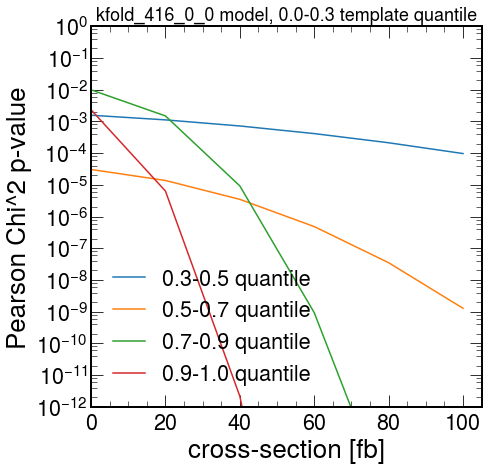

In [35]:
fig = plt.figure(figsize=(7, 7)) # figsize=(5, 5)
# Load CMS style sheet
plt.style.use(hep.style.CMS)
# define color palett for pvalue plotting
palette = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
                    '#bcbd22', '#17becf']    


for quant, eff, c in zip(quants[template_q_idx+1:], effs, palette):
    
    dat = hist_data[quant]
    p_vals = [scipy.stats.chisquare(f_obs=dat[xsec], f_exp=dat_tmplt[xsec]*eff, axis=0).pvalue for xsec in xsecs_sig]
        
    label = '{}-{} quantile'.format((quants+['1.0'])[quants.index(quant)], (quants+['1.0'])[quants.index(quant)+1])
    plt.semilogy(xsecs_sig, p_vals, color=c, label=label)
    
plt.legend(loc='best')
plt.xlabel('cross-section [fb]')
plt.ylabel('Pearson Chi^2 p-value')
plt.ylim(bottom=1e-12, top=1)
plt.xlim(left=0)

# set yticks manually
plt.gca().tick_params(direction='in', which='both')
plt.gca().minorticks_on()
locmaj = mpl.ticker.LogLocator(base=10, numticks=15) 
plt.gca().yaxis.set_major_locator(locmaj)
locmin = mpl.ticker.LogLocator(base=10.0, subs=(0.2,0.4,0.6,0.8), numticks=15)
plt.gca().yaxis.set_minor_locator(locmin)
plt.gca().yaxis.set_minor_formatter(mpl.ticker.NullFormatter())

plt.title('{} model, {}-{} template quantile'.format(qr_model_str,quants[template_q_idx],quants[template_q_idx+1]), fontsize=18)

    #plt.title('{} model, {}-{} template q, {}-{:.2f} test q {} binning'.format(qr_model_str,quants[template_q_idx+1],quants[template_q_idx], (quants+['0.0'])[quants.index(quant)+1], (quants+['0.0'])[quants.index(quant)], 'dijet' if dijet_binning else 'linear' ))

### poisson likelihood pval

Text(0.5, 1.0, 'kfold_416_0_0 model, 0.0-0.3 template quantile')

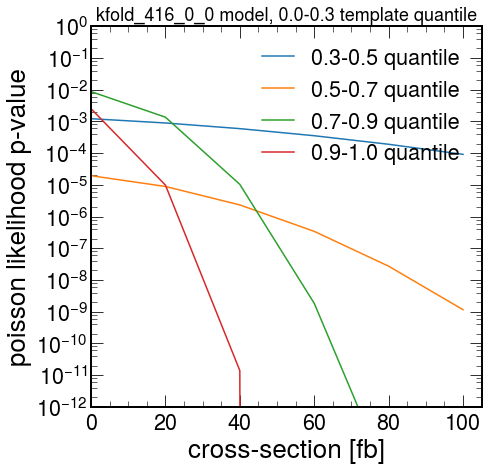

In [36]:
fig = plt.figure(figsize=(7, 7)) # figsize=(5, 5)
# Load CMS style sheet
plt.style.use(hep.style.CMS)
# define color palett for pvalue plotting
palette = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
                    '#bcbd22', '#17becf']    


for quant, eff, c in zip(quants[template_q_idx+1:], effs, palette):
    
    dat = hist_data[quant]
    
    p_vals = []
    
    for xsec in xsecs_sig:
    
        t_l, _ = chi_square_poisson_likeli(dat[xsec], dat_tmplt[xsec]*eff)
        pval_l = 1 - chi2.cdf(t_l, df=df)
        p_vals.append(pval_l)
        
    label = '{}-{} quantile'.format((quants+['1.0'])[quants.index(quant)], (quants+['1.0'])[quants.index(quant)+1])
    plt.semilogy(xsecs_sig, p_vals, color=c, label=label)
    
plt.legend(loc='best')
plt.xlabel('cross-section [fb]')
plt.ylabel('poisson likelihood p-value')
plt.ylim(bottom=1e-12, top=1)
plt.xlim(left=0)

# set yticks manually
plt.gca().tick_params(direction='in', which='both')
plt.gca().minorticks_on()
locmaj = mpl.ticker.LogLocator(base=10, numticks=15) 
plt.gca().yaxis.set_major_locator(locmaj)
locmin = mpl.ticker.LogLocator(base=10.0, subs=(0.2,0.4,0.6,0.8), numticks=15)
plt.gca().yaxis.set_minor_locator(locmin)
plt.gca().yaxis.set_minor_formatter(mpl.ticker.NullFormatter())

plt.title('{} model, {}-{} template quantile'.format(qr_model_str,quants[template_q_idx],quants[template_q_idx+1]), fontsize=18)

    #plt.title('{} model, {}-{} template q, {}-{:.2f} test q {} binning'.format(qr_model_str,quants[template_q_idx+1],quants[template_q_idx], (quants+['0.0'])[quants.index(quant)+1], (quants+['0.0'])[quants.index(quant)], 'dijet' if dijet_binning else 'linear' ))

## Kolmogorov-Smirnov 2-sample test

In [76]:
# empirical CDF
def ecdf(pdf):
    cdf = np.cumsum(pdf)
    return cdf / cdf[-1]

In [77]:
def kolmogorov_smirnov(observed, expected):
    obs_cdf = ecdf(observed)
    exp_cdf = ecdf(expected)
    return max(abs(obs_cdf-exp_cdf))

In [78]:
def pval_ks(ks_t, n, m):
    # Calculates the P-Value based on the two-sided test
    # The P-Value comes from the KS Distribution Survival Function (SF = 1-CDF)
    en = m * n / (m + n)
    return kstwo.sf(ks_t, np.round(en))

In [79]:
ks_stats = {}

for quant_test, eff in zip(quants[template_q_idx+1:], effs):
    
    test_stat_xsecs_ks = []
    pvals_ks = []
    
    for xsec in xsecs_sig:
        observed = hist_data[quant_test][xsec]
        expected = hist_data[quant_tmplt][xsec]*eff
        n, m = float(np.sum(observed)), float(np.sum(expected))
        t_ks = kolmogorov_smirnov(observed, expected)
        p_ks = pval_ks(t_ks, n, m)
        
        test_stat_xsecs_ks.append(t_ks)
        pvals_ks.append(p_ks)
    
    print('KS for quantile', quant_test)
    print('t:' , np.array(test_stat_xsecs_ks))
    print('p-val: ', np.array(pvals_ks))
    print('\n')
    
    ks_stats[quant_test] = test_stat_xsecs_ks

KS for quantile 0.3
t: [0.0008 0.0008 0.0008 0.0008 0.0008 0.0008]
p-val:  [0.484  0.4779 0.4718 0.4658 0.4598 0.4539]


KS for quantile 0.5
t: [0.0025 0.0026 0.0026 0.0026 0.0026 0.0026]
p-val:  [8.3679e-07 6.3064e-07 4.7400e-07 3.5533e-07 2.6566e-07 1.9809e-07]


KS for quantile 0.7
t: [0.0027 0.0026 0.0025 0.0025 0.0024 0.0024]
p-val:  [1.9464e-07 3.8083e-07 7.3453e-07 1.3965e-06 2.6173e-06 3.8145e-06]


KS for quantile 0.9
t: [0.0011 0.001  0.0009 0.0008 0.0009 0.0009]
p-val:  [0.5094 0.6443 0.7794 0.8272 0.7836 0.7375]




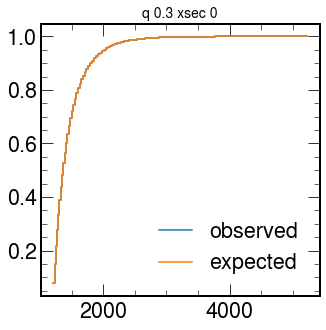

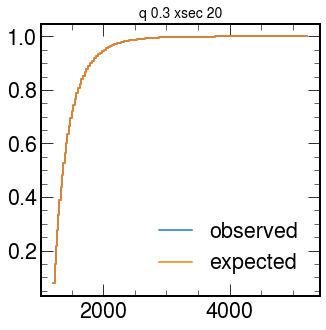

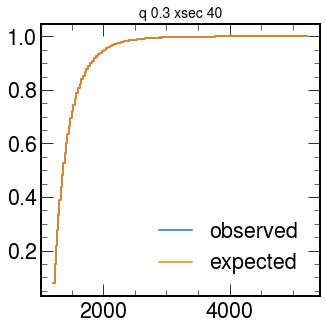

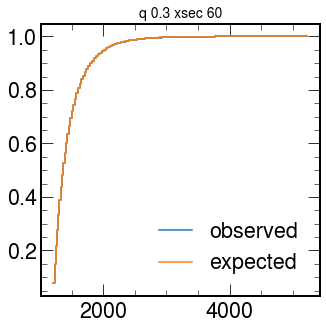

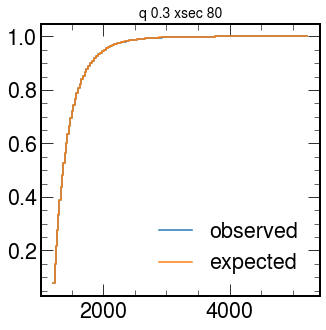

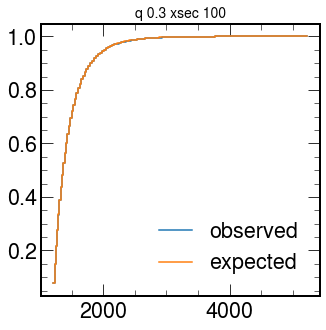

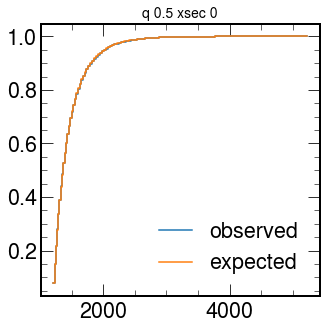

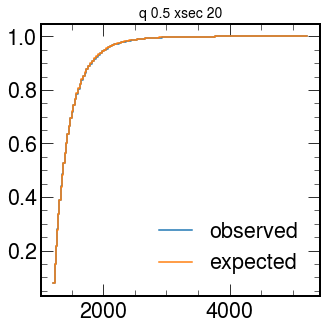

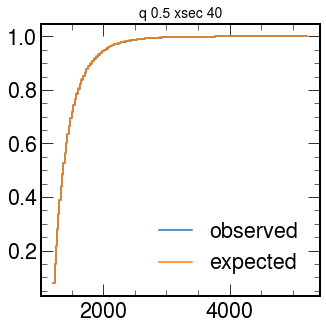

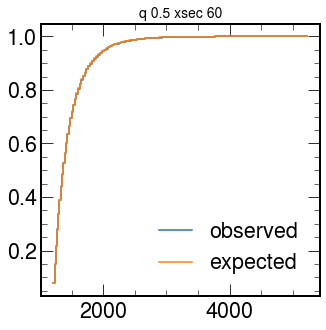

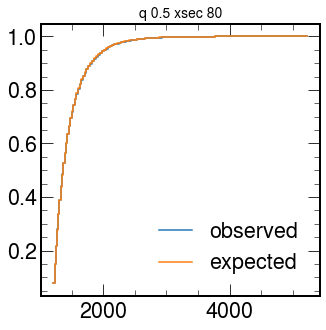

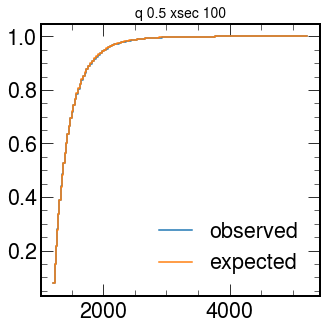

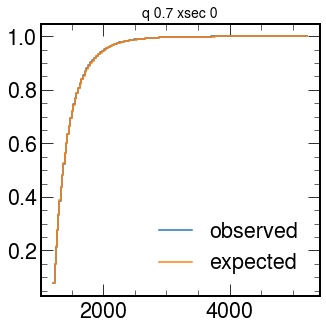

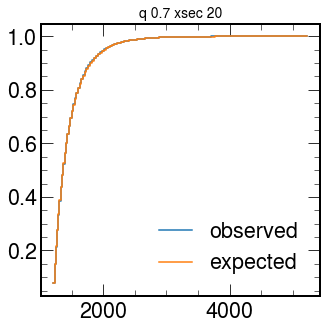

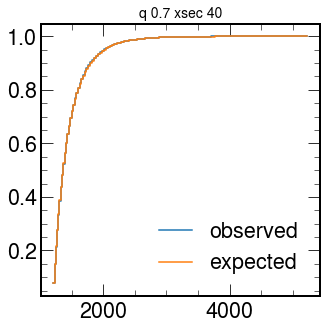

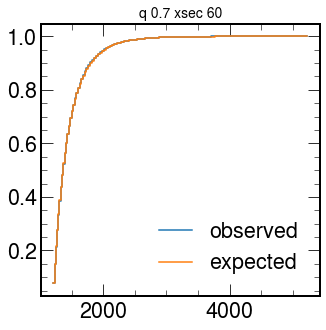

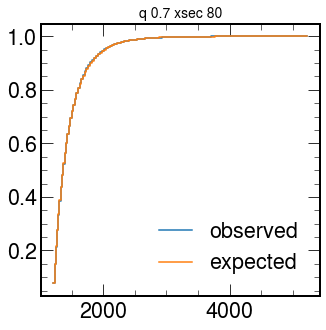

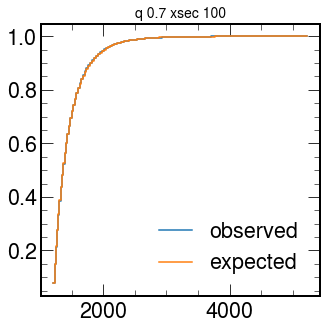

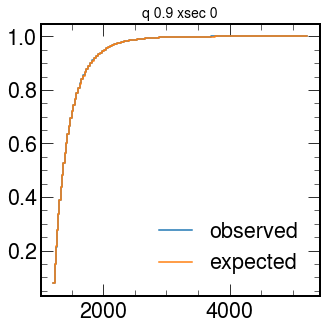

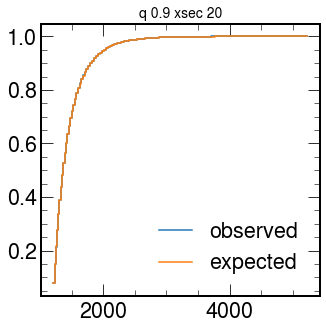

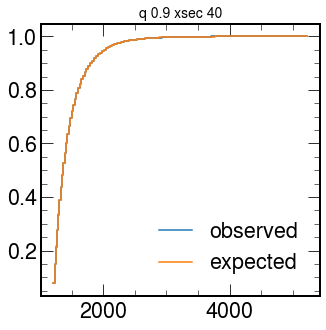

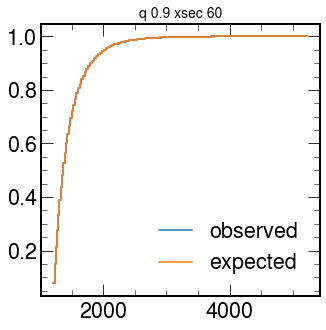

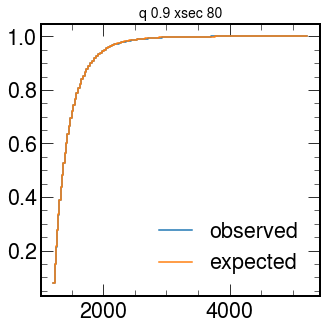

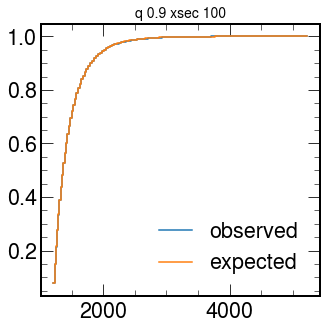

In [80]:
for quant_test, eff in zip(quants[template_q_idx+1:], effs):
    
    for xsec in xsecs_sig:
        observed = hist_data[quant_test][xsec]
        expected = hist_data[quant_tmplt][xsec]*eff
        obs_ecdf = ecdf(observed)
        exp_ecdf = ecdf(expected)
        
        fig = plt.figure(figsize=(5,5))
        plt.plot(bin_edges[:-1], obs_ecdf, label='observed', drawstyle='steps-post')
        plt.plot(bin_edges[:-1], exp_ecdf, label='expected', drawstyle='steps-post')
        plt.title('q {} xsec {}'.format(quant_test, xsec), fontsize=14)
        plt.legend(loc='best')
        plt.show()


## KS from pdfs

In [44]:
mjj_vals_qcd, mjj_vals_sig = read_raw_selection_data(quants, 113, params.qr_run_n, sample_id_sig, xsec_train, paths)

NameError: name 'paths' is not defined

In [ ]:
for quant_test, eff in zip(quants[template_q_idx+1:], effs):
    
    for xsec in xsecs_sig:
        observed = hist_data[quant_test][xsec]
        expected = hist_data[quant_tmplt][xsec]*eff
        obs_ecdf = ecdf(observed)
        exp_ecdf = ecdf(expected)
        
        fig = plt.figure(figsize=(5,5))
        plt.plot(bin_edges[:-1], obs_ecdf, label='observed', drawstyle='steps-post')
        plt.plot(bin_edges[:-1], exp_ecdf, label='expected', drawstyle='steps-post')
        plt.title('q {} xsec {}'.format(quant_test, xsec), fontsize=14)
        plt.legend(loc='best')
        plt.show()


In [ ]:
len(mjj_vals_sig)

In [ ]:
def get_ks_test_stat_pval(data1, data2):
    data1 = np.sort(data1)
    data2 = np.sort(data2)
    n1 = data1.shape[0]
    n2 = data2.shape[0]
    data_all = np.concatenate([data1, data2])
    # using searchsorted solves equal data problem
    cdf1 = np.searchsorted(data1, data_all, side='right') / n1
    cdf2 = np.searchsorted(data2, data_all, side='right') / n2
    t_ks = np.max(np.abs(cdf1 - cdf2))
    m, n = sorted([float(n1), float(n2)], reverse=True)
    en = m * n / (m + n)
    prob = kstwo.sf(t_ks, np.round(en))
    return t_ks, prob

In [ ]:
def get_ks_test_stat_pval_from_cdf(cdf1, cdf2, n1, n2):
    t_ks = np.max(np.abs(cdf1 - cdf2))
    m, n = sorted([float(n1), float(n2)], reverse=True)
    en = m * n / (m + n)
    prob = kstwo.sf(t_ks, np.round(en))
    return t_ks, prob

In [ ]:
s1 = np.random.normal(size=100000)
s2 = np.random.normal(size=100000)

In [ ]:
from scipy import stats
stats.ks_2samp(s1, s2)

In [ ]:
counts1, _, _ = plt.hist(s1, bins=100)
counts2, _, _ = plt.hist(s2, bins=100)
n1, n2 = float(len(s1)), float(len(s2))
cdf1 = np.cumsum(counts1)
cdf1 = cdf1 / cdf1[-1]
cdf2 = np.cumsum(counts2)
cdf2 = cdf2 / cdf2[-1]
t_ks, p_ks = get_ks_test_stat_pval_from_cdf(cdf1, cdf2, n1, n2)

In [ ]:
print(t_ks, p_ks)

In [ ]:
fig = plt.figure(figsize=(5,5))
plt.plot(counts1, label='counts_1', drawstyle='steps-post')
plt.plot(counts2, label='counts_2', drawstyle='steps-post')
plt.title('q {} xsec {}'.format(quant_test, xsec), fontsize=14)
plt.legend(loc='best')
plt.show()

In [ ]:
fig = plt.figure(figsize=(5,5))
plt.plot(cdf1, label='cdf1', drawstyle='steps-post')
plt.plot(cdf2, label='cdf2', drawstyle='steps-post')
plt.title('q {} xsec {}'.format(quant_test, xsec), fontsize=14)
plt.legend(loc='best')
plt.show()

In [53]:
s1 = np.random.normal(loc=1, size=10000)
s2 = np.random.normal(loc=2, size=100)

In [54]:
stats.ks_2samp(s1, s2)

KstestResult(statistic=0.379, pvalue=2.7766677845875165e-13)

In [55]:
s1 = np.random.normal(scale=1, size=10000)
s2 = np.random.normal(scale=2, size=100)
stats.ks_2samp(s1, s2)

KstestResult(statistic=0.207, pvalue=0.0003385066199647069)